# The Investigation on House Values for Zillow

### **Project Goal**
To find a regression model that can predict the value of a single family property with a much higher accuracy than the baseline prediction. 

## Imports

In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import user, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
#stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import os
directory = os.getcwd()

## Data Dictionary


| Feature | Definition |
|:--------|:-----------|
| id | Unique identifier for a property record |
| bedroomcnt, bedrooms | The number of bedrooms in the property |
| bathroomcnt, bathrooms | The number of bathrooms in the property, including partial bathrooms |
| calculatedfinishedsquarefeet, sqft | The total square footage of the property as calculated from public records |
| yearbuilt | The year the property was originally constructed |
| fips, county | Federal Information Processing Standards code representing the county in which the property is located |
| latitude | The latitude coordinate of the property |
| longitude | The longitude coordinate of the property |
| transactiondate, transaction_date | The date the property transaction was recorded |
| propertylandusedesc, property_class | The type or use of land the property is classified under |
| taxvaluedollarcnt, **taxvalue** | The total tax assessed value of the property |
| percentile_rank  | The percentile rank of the property based on the house square feet |



## Acquire
- get the data into pandas
- look at it
    - describe, info, head, shape
- understand what your data means
    - know what each column is
    - know what your target variable is

#### - Data acquired from the CodeUp mySQL server, the zillow database was gathered during the Tobias cohort.
#### - Size of data ((65418 rows, 13 columns)
#### - SQL query that imports the data focuses on non-nulls
#### - Each row represents a single family home transaction
#### - Each column represents a feature for the transaction

## Zillow data

In [2]:
# calling the first 3 rows of the zillow data
df_zillow = w.get_zillow_data()
df_zillow.head(3)

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,latitude,longitude,transactiondate,propertylandusedesc,taxvaluedollarcnt,percentile_rank
0,76757,2.0,1.0,704.0,1923.0,6037.0,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138.0,0.010022
1,6554,2.0,1.0,704.0,1922.0,6037.0,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000.0,0.010022
2,8438,2.0,1.0,704.0,1924.0,6037.0,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490.0,0.010022


In [3]:
# How big is the dataset?
df_zillow.shape

(54566, 12)

In [4]:
# checking for nulls
df_zillow.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
yearbuilt                       0
fips                            0
latitude                        0
longitude                       0
transactiondate                 0
propertylandusedesc             0
taxvaluedollarcnt               2
percentile_rank                 0
dtype: int64

In [5]:
# Understanding the data and math of its numbers
df_zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
id,54566.0,3.873712e+04,22373.793959,2.000000e+01,1.949525e+04,3.887350e+04,5.720075e+04,7.761100e+04
bedroomcnt,54566.0,3.307572e+00,0.884196,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
bathroomcnt,54566.0,2.226900e+00,0.897360,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
calculatedfinishedsquarefeet,54566.0,1.829531e+03,779.309537,7.040000e+02,1.269000e+03,1.631000e+03,2.200000e+03,5.264000e+03
yearbuilt,54566.0,1.961212e+03,21.685928,1.862000e+03,1.950000e+03,1.958000e+03,1.975000e+03,2.016000e+03
fips,54566.0,6.048822e+03,21.160269,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,54566.0,3.401613e+07,249330.503864,3.334071e+07,3.383611e+07,3.401633e+07,3.418175e+07,3.480695e+07
longitude,54566.0,-1.182051e+08,351913.513378,-1.194484e+08,-1.184020e+08,-1.181567e+08,-1.179491e+08,-1.175559e+08
taxvaluedollarcnt,54564.0,4.314962e+05,448560.169622,7.584000e+03,1.890078e+05,3.295140e+05,5.280518e+05,1.472112e+07
percentile_rank,54566.0,4.997561e-01,0.283010,1.002173e-02,2.548537e-01,4.998473e-01,7.446793e-01,9.899962e-01


# Prepare
#### Prepare
- perform univariate stats
- clean up data
- encode data
- split data
#### Prepare Actions:
- Removed columns that did not contain useful information
- Renamed columns to promote readability
- Checked for nulls in the data (there were none)
- Checked that column data types were appropriate
- Added additional features to investigate:
    - rm_X_sqft
- Compare categorical variables
- Split data into train(60), validate(20) and test(20) (no stratifying)
- Scale continuous variable
- Outliers within 1% of max or min of square feet (sqft) have been removed for this iteration of the project

In [6]:
# After some cleaning, calling the cleaner data without the nulls and dropping the top and bottom 1% when ranked by sqft.
df = w.prep_zillow(w.get_zillow_data())
df.head(3)

,id,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,percentile_rank
0,76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138,0.010022
1,6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000,0.010022
2,8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490,0.010022


In [7]:
# setting id as the index and dropping the percentile column as it is no longer needed
df = df.set_index('id')
df.drop(['percentile_rank'], axis=1, inplace=True)
df.head(3)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue
id,,,,,,,,,,
76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138
6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000
8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490


In [8]:
# feature engineering, creating a new column 
df['rm_X_sqft'] = round((df['bathrooms'] + df['bedrooms'])/df['sqft'], 6)
df.head(3)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,rm_X_sqft
id,,,,,,,,,,,
76757,2,1.0,704,1923,LA,34290119.0,-118438171.0,2017-09-14,Single Family Residential,262138,0.004261
6554,2,1.0,704,1922,LA,33974852.0,-118295536.0,2017-01-30,Single Family Residential,247000,0.004261
8438,2,1.0,704,1924,LA,33850843.0,-118385100.0,2017-02-07,Single Family Residential,50490,0.004261


In [9]:
# inversigating the types of datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54564 entries, 76757 to 68525
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          54564 non-null  int64  
 1   bathrooms         54564 non-null  float64
 2   sqft              54564 non-null  int64  
 3   yearbuilt         54564 non-null  int64  
 4   county            54564 non-null  object 
 5   latitude          54564 non-null  float64
 6   longitude         54564 non-null  float64
 7   transaction_date  54564 non-null  object 
 8   property_class    54564 non-null  object 
 9   taxvalue          54564 non-null  int64  
 10  rm_X_sqft         54564 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 5.0+ MB


In [10]:
# checking the final size of my dataset before exploring and splitting
df.shape

(54564, 11)

In [11]:
# making sure there is no nulls before exploring and splitting
df.isnull().sum()

bedrooms            0
bathrooms           0
sqft                0
yearbuilt           0
county              0
latitude            0
longitude           0
transaction_date    0
property_class      0
taxvalue            0
rm_X_sqft           0
dtype: int64

In [12]:
# how many per area?
pd.crosstab(df.property_class, df.county)

county,LA,Orange,Ventura
property_class,,,
Single Family Residential,36217,13705,4642


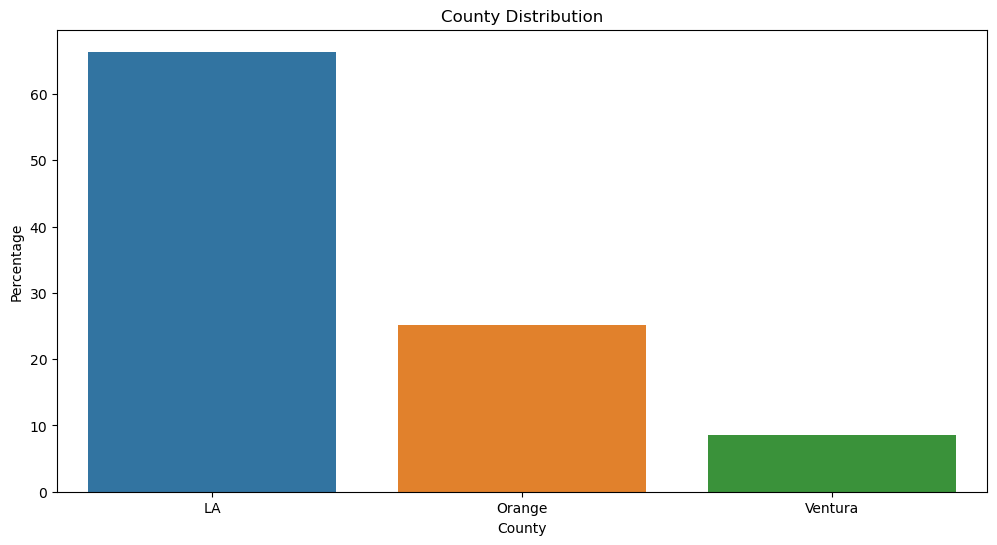

In [13]:
# Get the value counts, normalized to percentage
county_counts = df['county'].value_counts(normalize=True).reset_index()

# Convert to percentage
county_counts.columns = ['County', 'Percentage']
county_counts['Percentage'] *= 100

# Plot the results as a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='County', y='Percentage', data=county_counts)

# Set the title and labels
plt.title('County Distribution')
plt.xlabel('County')
plt.ylabel('Percentage')

# Show the plot
plt.show()


# Explore

### Univariate Analysis pre-scaling

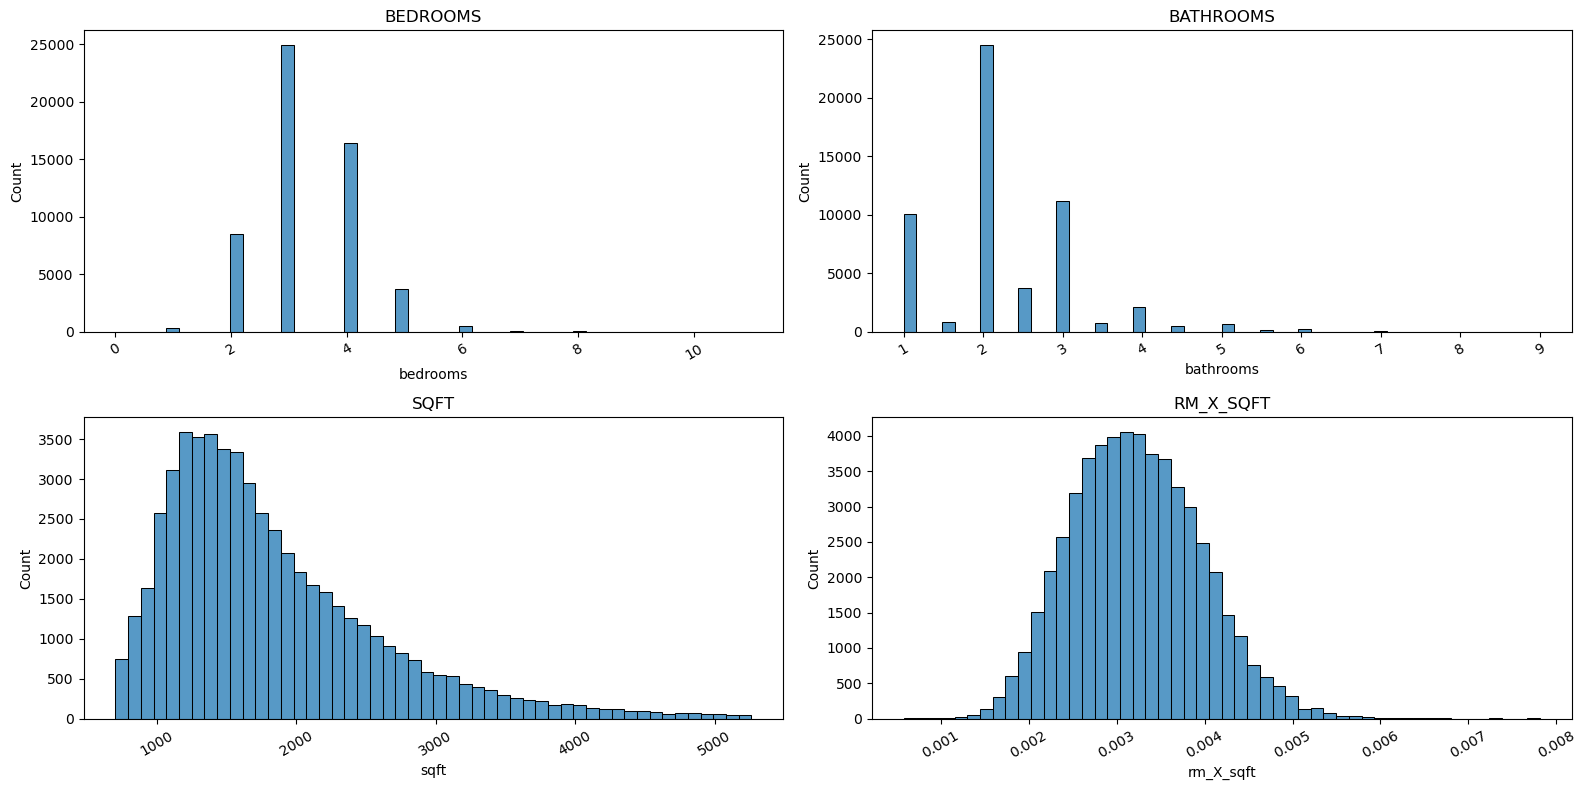

In [14]:
#creating a list of columns that i want to investigate deeper
cols = ['bedrooms', 'bathrooms', 'sqft', 'rm_X_sqft']

# Determine the number of rows needed for subplots
n_rows = len(cols) // 2 + len(cols) % 2
fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows*4))

for i, col in enumerate(cols):
    ax = axes.flatten()[i]
    sns.histplot(df[col], bins=50, ax=ax)  # Using seaborn for a more refined look
    ax.set_title(col.upper(), fontsize=12)  # Set title for each subplot
    ax.tick_params(axis='x', rotation=30)   # Rotate x-axis labels
    ax.grid(False)  # Hide gridlines

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Spliting

#### NOTES:
- only using NON-NULLs
- removed 1% of top and bottom (2% total) values using the feature ranking 'sqft' as to remove possible human error in istances where '0' or an exaggerated number was imputed for the 'sqft' feature.
- I created a feature (column) named 'rm_X_sqft' as a result of dividing ('bedrooms' and 'bathrooms') by 'sqft'

In [15]:
# using the split function to split my data into 60, 20, 20
train, validate, test = w.split_data(df)


    train -> (32738, 11)
    validate -> (10913, 11)
    test -> (10913, 11)


In [16]:
# scaling the data
# separating X and y
X_train, y_train = train.drop(columns=['taxvalue','county','transaction_date', 'property_class']), train['taxvalue']
X_validate, y_validate = validate.drop(columns=['taxvalue','county','transaction_date', 'property_class']), validate['taxvalue']
X_test, y_test = test.drop(columns=['taxvalue','county','transaction_date', 'property_class']), test['taxvalue']

In [17]:
# setting a Spearman correlatioin value 
zillow_corr = train.corr(method='spearman')

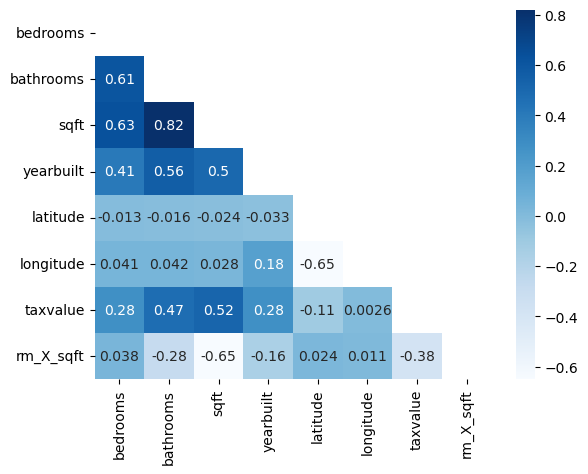

In [18]:
# pass my correlation matrix to Seaborn's heatmap with customization
sns.heatmap(zillow_corr, cmap='Blues', annot=True, 
            mask=np.triu(zillow_corr))
plt.show()

## Hypotheses:

### Q1. Is there a relationship between sqft and taxvalue? (using Spearman)

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between sqft and taxvalue

$H_a$: There is a linear correlation between sqft and taxvalue

In [19]:
# Variables are not normally distributed
# using scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.sqft, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.516475
P-value: 0.0


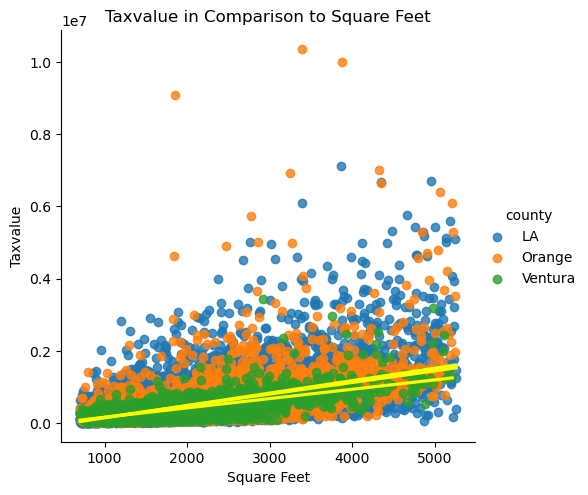

In [20]:
# Using sns to plot the correlation between taxvalue and sqft, with a hue of county and a best fit line for each county
sns.lmplot(data=train, x='sqft', y='taxvalue', markers='o',
           line_kws={'color':'yellow'},aspect=1,hue='county')
plt.title('Taxvalue in Comparison to Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Taxvalue')
plt.show()

### The SpearmanR test shows there is a monotonic relationship between sqft and taxvalue

### There seems to be a great correlation between sqft and taxvalue, as sqft increases, taxvalue also increases.  Which makes sense as the larger the constructed house, themore material it takes to be built, therefore more expensive. 

## Hypotheses:

### Q2. Is there a relationship between number of bedrooms and taxvalue? (using Spearman)

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between number of bedrooms and taxvalue

$H_a$: There is a linear correlation between number of bedrooms and taxvalue

In [21]:
# using scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.bedrooms, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.275966
P-value: 0.0


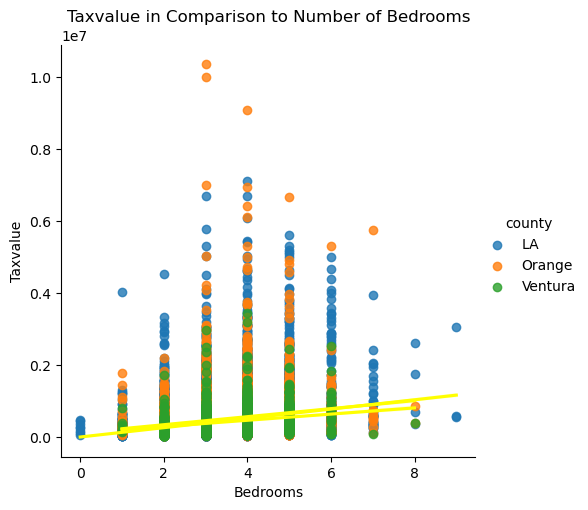

In [22]:
# I can really pop that line color if I want
sns.lmplot(data=train, x='bedrooms', y='taxvalue',hue='county',
           line_kws={'color':'yellow'})
plt.title('Taxvalue in Comparison to Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Taxvalue')
plt.show()

### the SpearmanR test shows there is a monotonic relationship between number of bedrooms and taxvalue

### There seems to be a great correlation between number of bedrooms and taxvalue, as the number of bedrooms increases (up to 5) the value increases, after 5, the taxvalue is less reflected on number of bedrooms. 

## Hypotheses:

### Q3. Is there a relationship between number of bathrooms and taxvalue? (using Spearman)

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between number of bathrooms and taxvalue

$H_a$: There is a linear correlation between number of bathrooms and taxvalue

In [23]:
# Since my variables are not normally distributed, 
# use scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.bathrooms, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.470569
P-value: 0.0


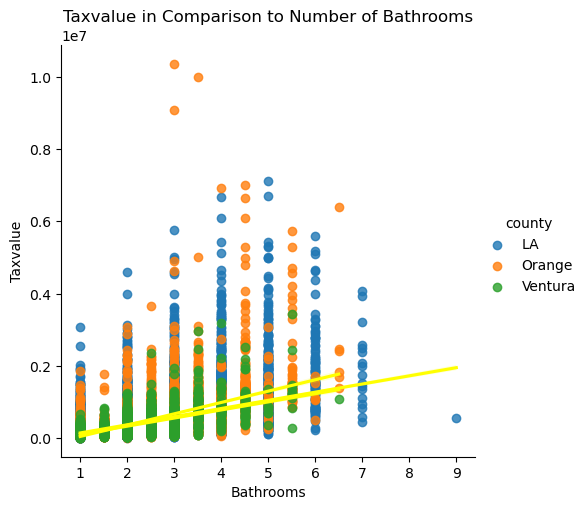

In [24]:
# crating a plot of taxvalue and baths
sns.lmplot(data=train, x='bathrooms', y='taxvalue',hue='county',
           line_kws={'color':'yellow'})
plt.title('Taxvalue in Comparison to Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Taxvalue')
plt.show()

### The SpearmanR test shows there is a monotonic relationship between number of bathrooms and taxvalue

### There seems to be a great correlation between number of bathrooms and taxvalue, as the number of bathrooms increases (up to 6.5) the value increases, after 7, the taxvalue is less reflected on number of bathrooms. 

## Exploration Summary
#### * SpearmanR test shows a **monotonic relationship between sqft and taxvalue**
#### * SpearmanR test shows a **monotonic relationship between bathrooms and taxvalue**
#### * SpearmanR test shows a **monotonic relationship between bedrooms and taxvalue**

# Modeling
* Will scale all continious features for modeling
* Created a baseline by taking the mean of taxvalue.
* I will be using the following models to evaluate:  
     - Ordinary Least Squares
     - LassoLars
     - Polynomial Regression
### Scaling
* scaler = MinMaxScaler() to all data sets
* fit to train ONLY*

In [25]:
# make a scaler:
scaler = MinMaxScaler()
# fit and use a scaler:
X_train_scaled = scaler.fit_transform(X_train)
# use only on validate:
X_validate_scaled = scaler.transform(X_validate)
# use only on test:
X_test_scaled = scaler.transform(X_test)

In [26]:
# setting values for train group
X = X_train
y = y_train
# BASELINE
baseline = y.mean()
round(baseline,2)

429627.86

### Baseline
* $438693.65

In [27]:
# making a baseline guess dataframe
# that is the same shape as our y variable:
# np.repeat does what it sounds like
baseline_array = np.repeat(baseline, y.shape[0])
baseline_rmse, baseline_r2 = w.evaluate_reg(y, baseline_array)

In [28]:
# setting up a dictionary to add the results of the models
eval_df = pd.DataFrame([{
    'Model': 'baseline',
    'rmse': baseline_rmse,
    'r2': baseline_r2
}])
eval_df

,Model,rmse,r2
0,baseline,438693.652757,0.0


### MODEL: LassoLars
* train
* Validate

In [29]:
# fit a version of this that has an alpha of 1:
# make it
lasso = LassoLars(alpha=1)
# fit it:
lasso = lasso.fit(X, y)

In [30]:
# Evaluate
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = w.evaluate_reg(y, lasso.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Model': 'lasso',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Model,rmse,r2
0,baseline,438693.652757,0.000000
1,lasso,345489.434750,0.379778


In [31]:
# doing the same for validate sample data
val_rmse, val_r2 = w.evaluate_reg(y_validate, lasso.predict(X_validate))
val_dict = pd.DataFrame([{
    'Val_Model': 'lasso',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}])
val_scores = [val_dict]
val_scores.append([val_dict])
val_dict

,Val_Model,val_rmse,val_r2
0,lasso,369635.570777,0.37247


## MODEL: Polynomial Regression
* train
* Validate

In [32]:
# do a preprocessing step with our training data
# x^2
pf = PolynomialFeatures(degree=2)
# fit the thing, also use it
x_train_sq = pf.fit_transform(X)
# use this transformer to change our val and test:
x_val_sq = pf.transform(X_validate)
x_test_sq = pf.transform(X_test)

In [33]:
# make a new model for our polynomial regressor:
plyreg = LinearRegression()
plyreg.fit(x_train_sq, y)

LinearRegression()

In [34]:
# pd.concatin into eval the second model on train

rmse, r_2 = w.evaluate_reg(y, plyreg.predict(x_train_sq))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Model': 'quad_reg',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Model,rmse,r2
0,baseline,438693.652757,0.000000
1,lasso,345489.434750,0.379778
2,quad_reg,336084.305147,0.413087


In [35]:
# concating on val_dict to add the second model on validate
val_rmse, val_r2 = w.evaluate_reg(y_validate, plyreg.predict(x_val_sq))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val_Model': 'quad_reg',
    'val_rmse': val_rmse,
    'val_r2': val_r2
})])], ignore_index=True, axis=0)
val_scores.append([val_dict])
val_dict

,Val_Model,val_rmse,val_r2
0,lasso,369635.570777,0.372470
1,quad_reg,356379.478561,0.416672


### MODEL: Ordinary Least Squares (OLS) (3)
* train
* Validate

In [36]:
# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe = RFE(lr1, n_features_to_select=3)

# fit
rfe.fit(X, y)

# transform
X_train_rfe = rfe.transform(X)

X_val_rfe = rfe.transform(X_validate)

In [37]:
# feature that it selected?
rfe.get_feature_names_out()

array(['bedrooms', 'bathrooms', 'rm_X_sqft'], dtype=object)

In [38]:
# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe, y)

LinearRegression()

In [39]:
# pd.concat is a one-liner so I dont really feel the need to
# create a whole new function for this atm even though
# we will do it a few times:
rmse, r_2 = w.evaluate_reg(y, lr1.predict(X_train_rfe))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Model': 'ols_rfe_1',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Model,rmse,r2
0,baseline,438693.652757,0.000000
1,lasso,345489.434750,0.379778
2,quad_reg,336084.305147,0.413087
3,ols_rfe_1,366006.204054,0.303928


In [40]:
# third and final model on val
val_rmse, val_r2 = w.evaluate_reg(y_validate, lr1.predict(X_val_rfe))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val_Model': 'ols_rfe_1',
    'val_rmse': val_rmse,
    'val_r2': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val_Model,val_rmse,val_r2
0,lasso,369635.570777,0.372470
1,quad_reg,356379.478561,0.416672
2,ols_rfe_1,391909.297100,0.294563


## Models as Residual

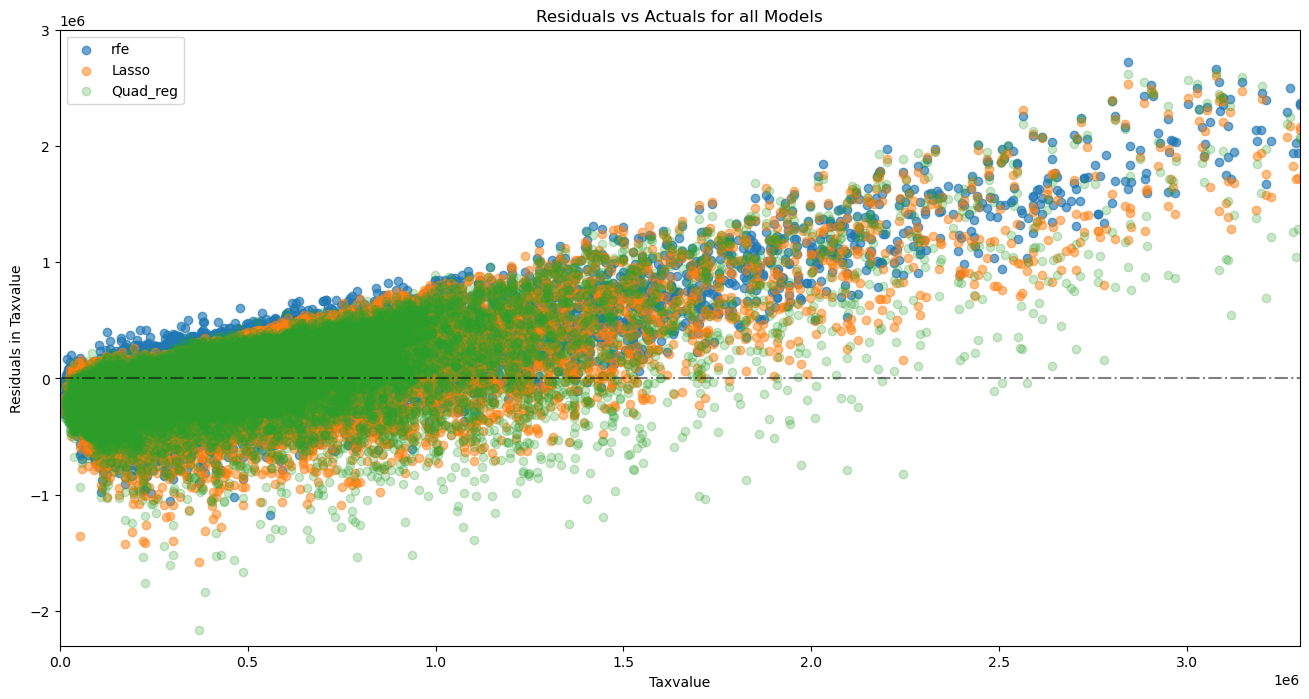

In [41]:
# plotting the residuals of the model as compared to the actual
plt.figure(figsize=(16, 8))
plt.scatter(y, y - lr1.predict(X_train_rfe), label='rfe', alpha=0.65)
plt.scatter(y, y - lasso.predict(X), label='Lasso', alpha=0.5)
plt.scatter(y, y - plyreg.predict(x_train_sq), label='Quad_reg', alpha=0.25)
plt.title('Residuals vs Actuals for all Models')
plt.axhline(0, ls='-.', c='k', alpha=0.5)
plt.xlabel('Taxvalue')
plt.ylabel('Residuals in Taxvalue')
plt.legend()
# Set the axis limits
plt.xlim(left=0, right=3300000) 
plt.ylim(bottom=-2300000, top=3000000)
plt.show()

## Histogram os all Models and Actual Taxvalue

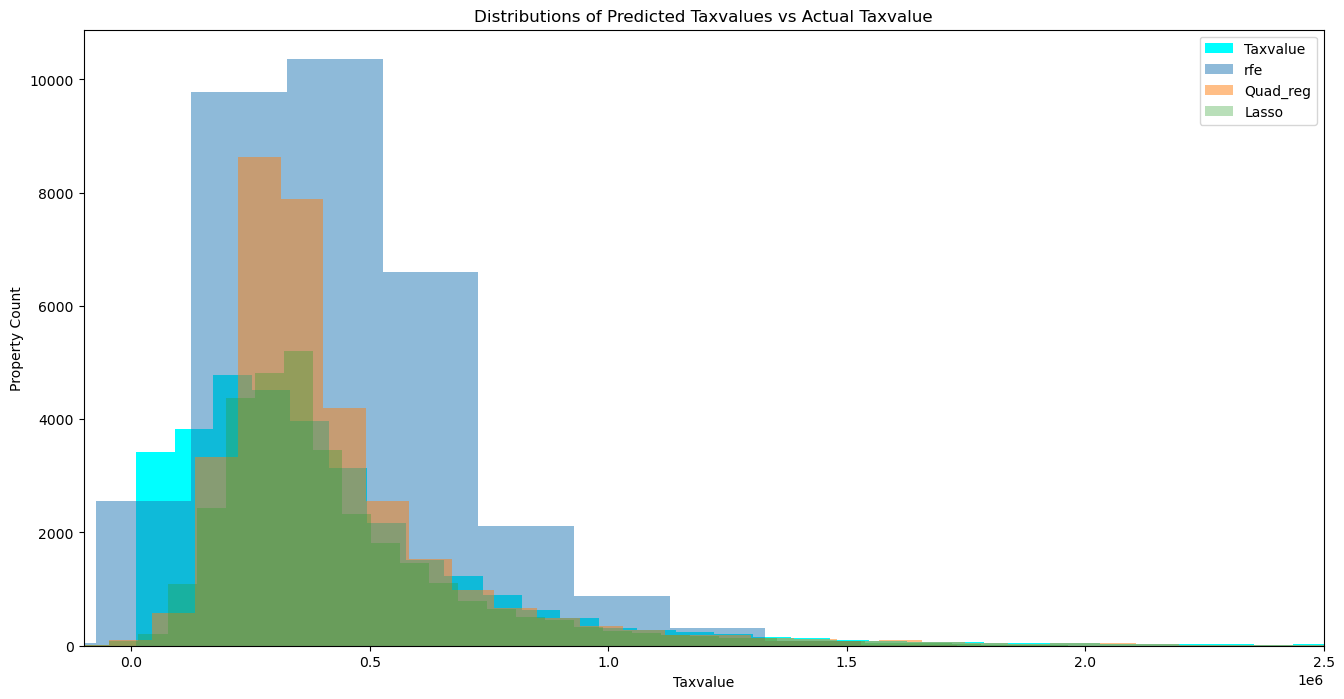

In [42]:
# Creating an overlay histogram of the train taxvalue and the 3 model predictions
plt.figure(figsize=(16,8))
plt.hist(y, alpha=1, label='Taxvalue',color='cyan',bins=128)
plt.hist(lr1.predict(X_train_rfe), alpha=0.5, label='rfe')
plt.hist(plyreg.predict(x_train_sq), label='Quad_reg', alpha=0.5,bins=36)
plt.hist(lasso.predict(X), label= 'Lasso', alpha=0.33, bins=36)
plt.legend()
plt.title('Distributions of Predicted Taxvalues vs Actual Taxvalue')
# Set the x-axis limits
plt.xlim(left=-100000, right=2500000)  # Replace max_x_value with your desired maximum value
plt.xlabel('Taxvalue')
plt.ylabel('Property Count')
plt.show()

## Based on the models tested, the best model is the Polynomial Regresion (*degree is set equal to 2*), where **$r^2$**= `0.353904` and **rmse**= `$355598.85`

### I will be using the Polynomial Regression (quad_reg) model on test. 

# TEST
## Using Polynomial Regression

In [43]:
# assigning variables to the model rmse and r^2
rmse_test, r_2_test = w.evaluate_reg(y_test, plyreg.predict(x_test_sq))
print(f'With the Polynomial Regression model: rmse on test sample was ${round(rmse_test,2)}, and the r^2 was {round(r_2_test,6)}')

With the Polynomial Regression model: rmse on test sample was $368887.31, and the r^2 was 0.354768


## Test model for the Polynomial Regresion, is **$r^2$**= `0.354768` and **rmse**= `$368887.31`

### Modeling Wrap 
#### With the Polynomial Regression model: rmse on test sample was **368887.31**, as opposed to baseline **438693.65**
#### Potential savings of **$69806.34** (**16%**) on averge as opposed to baseline.
* Use the model if no other model exist

## Conclusion

### Summery
* There is correlation between sqft and taxvalue, as sqft increases, taxvalue also increases.
* There is correlation between number of bedrooms and taxvalue, as the number of bedrooms increases (up to 5) the value increases.
* There is correlation between number of bathrooms and taxvalue, as the number of bathrooms increases (up to 6.5) the value increases.

### Recommendations
* Have more complete features, as the more features available for the models, the better for the model.
* Consider home renovations.

### Next Steps
* Create another model with the LassoLars model in mind and creating a new model by county